<a href="https://colab.research.google.com/github/ayushman1401/Amazon_Replica/blob/main/Tyres_BTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import cv2
import numpy as np
import os
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
!pip install ultralytics
from ultralytics import YOLO
# yolov8-seg-n
# training

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
master_dir="/content/drive/MyDrive/Project_Data (1)"
master_dir

'/content/drive/MyDrive/Project_Data (1)'

In [14]:
class TireAnalysisSystem:
    def __init__(self, yolo_model_path=f'{master_dir}/yolov11_small_epoch100.pt'):
        # Initialize models and parameters
        self.img_size = (128, 128)
        self.label_dict = {'flat': 0, 'full': 1, 'no-tire': 2}
        self.svm_model = None
        self.scaler = None
        self.yolo_model = None
        self.class_names = []

        # Load YOLO model if path provided
        if yolo_model_path:
            self.load_yolo_model(yolo_model_path)

    def load_yolo_model(self, model_path):
        """Load YOLO segmentation model"""
        self.yolo_model = YOLO(model_path)
        if hasattr(self.yolo_model, 'names'):
            self.class_names = self.yolo_model.names

    def train_tire_detector(self, dataset_path):
        """Train the tire deformation classifier"""
        # Load dataset
        flat_images, flat_labels = self._load_images_from_folder(os.path.join(dataset_path, 'flat.class'))
        full_images, full_labels = self._load_images_from_folder(os.path.join(dataset_path, 'full.class'))
        no_tire_images, no_tire_labels = self._load_images_from_folder(os.path.join(dataset_path, 'no-tire.class'))

        # Combine dataset
        images = flat_images + full_images + no_tire_images
        labels = ['flat']*len(flat_images) + ['full']*len(full_images) + ['no-tire']*len(no_tire_images)

        # Convert to numpy arrays
        images = np.array(images)
        labels = np.array([self.label_dict[label] for label in labels])

        # Normalize
        images = images / 255.0

        # Extract HOG features
        hog_features = self._extract_hog_features(images)

        # Standardize features
        self.scaler = StandardScaler()
        hog_features = self.scaler.fit_transform(hog_features)

        # Train SVM model
        self.svm_model = SVC(kernel='linear')
        self.svm_model.fit(hog_features, labels)

    def _load_images_from_folder(self, folder):
        """Helper function to load images from folder"""
        images = []
        labels = []
        for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, self.img_size)
                images.append(img)
                labels.append(folder.split('/')[-1].split('.')[0])  # Extract 'flat', 'full', etc.
        return images, labels

    def _extract_hog_features(self, images):
        """Extract HOG features from images"""
        hog_features = []
        for image in images:
            feature, _ = hog(image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=True)
            hog_features.append(feature)
        return np.array(hog_features)

    def detect_tires(self, image):
        """Detect tires in an image using contour analysis or YOLO"""
        if self.yolo_model:
            return self._detect_tires_yolo(image)
        else:
            return self._detect_tires_contour(image)

    def _detect_tires_contour(self, image):
        """Detect tires using traditional contour analysis"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)

        # Find contours
        contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter potential tires
        potential_tires = []
        for contour in contours:
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

            if len(approx) > 5:  # Circular shape
                (x, y, w, h) = cv2.boundingRect(contour)
                aspect_ratio = w / float(h)

                if 0.8 <= aspect_ratio <= 1.2 and w > 30 and h > 30:
                    potential_tires.append((x, y, w, h))

        return potential_tires

    def _detect_tires_yolo(self, image, target_classes=["wheel"]):
        """Detect tires using YOLO segmentation"""
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.yolo_model(img_rgb)

        tire_boxes = []
        for result in results:
            if result.masks is not None:
                for i, class_id in enumerate(result.boxes.cls.cpu().numpy().astype(int)):
                    class_name = self.class_names[class_id]
                    if class_name in target_classes:
                        box = result.boxes.xyxy[i].cpu().numpy().astype(int)
                        x1, y1, x2, y2 = box
                        tire_boxes.append((x1, y1, x2-x1, y2-y1))

        return tire_boxes

    def mask_segments(self, image_path, target_classes=["wheel"]):
        """Segment specific parts of the car using YOLO"""
        if not self.yolo_model:
            raise ValueError("YOLO model not loaded")

        img = cv2.imread(image_path)
        if img is None:
            print("Error loading image")
            return None

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = self.yolo_model(img_rgb)
        result = results[0]

        if result.masks is not None:
            masks = result.masks.data.cpu().numpy()
            class_ids = result.boxes.cls.cpu().numpy().astype(int)
            boxes = result.boxes.xyxy.cpu().numpy().astype(int)

            masked_image = img_rgb.copy()
            color = (255, 124, 124)  # Light Red

            for i, (mask, class_id, box) in enumerate(zip(masks, class_ids, boxes)):
                class_name = self.class_names[class_id]

                if class_name in target_classes:
                    x1, y1, x2, y2 = box
                    print(f"\nDetected '{class_name}':")
                    print(f"  Bounding Box: x1={x1}, y1={y1}, x2={x2}, y2={y2}")

                    # Binarize and resize mask
                    mask_bin = np.where(mask > 0.5, 1, 0).astype(np.uint8)
                    mask_resized = cv2.resize(mask_bin, (img.shape[1], img.shape[0]))

                    # Overlay mask on image
                    for c in range(3):
                        masked_image[..., c] = np.where(mask_resized == 1, color[c], masked_image[..., c])

                    # Draw bounding box
                    cv2.rectangle(masked_image, (x1, y1), (x2, y2), (255, 255, 255), 2)
                    cv2.putText(masked_image, class_name, (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            # Show final result
            plt.figure(figsize=(10, 8))
            plt.imshow(masked_image)
            plt.axis('off')
            plt.title("Masked Segments with Bounding Boxes")
            plt.show()
        else:
            print("No masks detected.")

    def analyze_motion_state(self, tire_roi, threshold=100):
        """Determine if tire is moving or stationary"""
        if len(tire_roi.shape) == 3:
            tire_roi = cv2.cvtColor(tire_roi, cv2.COLOR_BGR2GRAY)

        # Motion blur detection
        blurred = cv2.GaussianBlur(tire_roi, (5, 5), 0)
        edges = cv2.Canny(blurred, 50, 150)
        laplacian = cv2.Laplacian(tire_roi, cv2.CV_64F)
        variance = laplacian.var()

        if variance < threshold:
            return "Moving", variance
        else:
            return "Stationary", variance

    def analyze_deformation(self, tire_roi):
        """Classify tire as full or flat"""
        if self.svm_model is None:
            raise ValueError("Tire detector not trained. Call train_tire_detector() first.")

        # Preprocess
        gray = cv2.cvtColor(tire_roi, cv2.COLOR_BGR2GRAY) if len(tire_roi.shape) == 3 else tire_roi
        resized = cv2.resize(gray, self.img_size)
        normalized = resized / 255.0

        # Extract features and predict
        hog_feature = self._extract_hog_features([normalized])[0]
        hog_feature = self.scaler.transform([hog_feature])
        prediction = self.svm_model.predict(hog_feature)[0]

        # Map prediction to label
        reverse_dict = {v: k for k, v in self.label_dict.items()}
        return reverse_dict[prediction]

    def estimate_orientation(self, tire_roi, car_roi=None):
        """Estimate if tire is front or rear (simplified approach)"""
        height, width = tire_roi.shape[:2]
        center_x = width // 2

        if car_roi is not None:
            # More sophisticated analysis using car segmentation
            pass

        return "Front" if center_x < width/2 else "Rear"

    def analyze_image(self, image_path):
        """Complete analysis pipeline"""
        image = cv2.imread(image_path)
        if image is None:
            print("Error loading image")
            return None

        # Detect tires
        tire_boxes = self.detect_tires(image)
        if not tire_boxes:
            print("No tires detected")
            return None

        results = []
        for (x, y, w, h) in tire_boxes:
            tire_roi = image[y:y+h, x:x+w]

            # Analyze states
            motion_state, variance = self.analyze_motion_state(tire_roi)
            deformation = self.analyze_deformation(tire_roi)
            orientation = self.estimate_orientation(tire_roi)

            results.append({
                'position': (x, y, w, h),
                'motion': motion_state,
                'deformation': deformation,
                'orientation': orientation,
                'sharpness': variance
            })

            # Draw results on image
            label = f"{motion_state}, {deformation}, {orientation}"
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display results
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        return results


0: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 2 front_left_lights, 1 front_right_light, 1 hood, 1 left_mirror, 1 right_mirror, 1 wheel, 15.1ms
Speed: 2.8ms preprocess, 15.1ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)

Detected 'wheel':
  Bounding Box: x1=329, y1=168, x2=550, y2=299


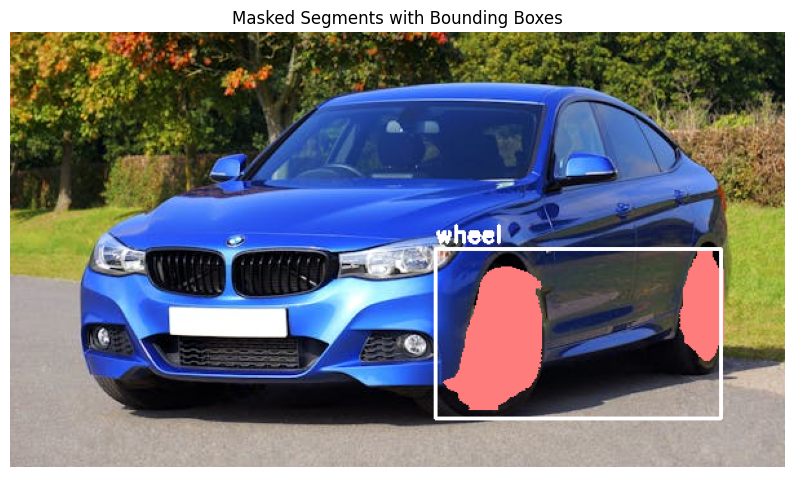

AttributeError: 'TireAnalysisSystem' object has no attribute 'detect_components'

In [95]:
# Initialize system with YOLO model (provide your model path)
yolo_model_path = f"{master_dir}/yolov11_small_epoch100.pt"  # Replace with your model path
analyzer = TireAnalysisSystem(yolo_model_path)

# Train with your dataset (uncomment and provide path)
# analyzer.train_tire_detector("path/to/your/dataset")

# Analyze your specific image
image_path = f"{master_dir}/car.jpg"

# Option 1: Just show segmentation
analyzer.mask_segments(image_path, ["wheel"])

# Option 2: Full analysis (requires trained deformation model)
results = analyzer.detect_components(image_path)
if results:
     for i, result in enumerate(results):
         print(f"Tire {i+1}:")
         print(f"  Position: {result['position']}")
         print(f"  Motion: {result['motion']} (Sharpness: {result['sharpness']:.1f})")
         print(f"  Deformation: {result['deformation']}")
         print(f"  Orientation: {result['orientation']}")


0: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 2 front_left_lights, 1 front_right_light, 1 hood, 1 left_mirror, 1 right_mirror, 1 wheel, 14.6ms
Speed: 2.1ms preprocess, 14.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


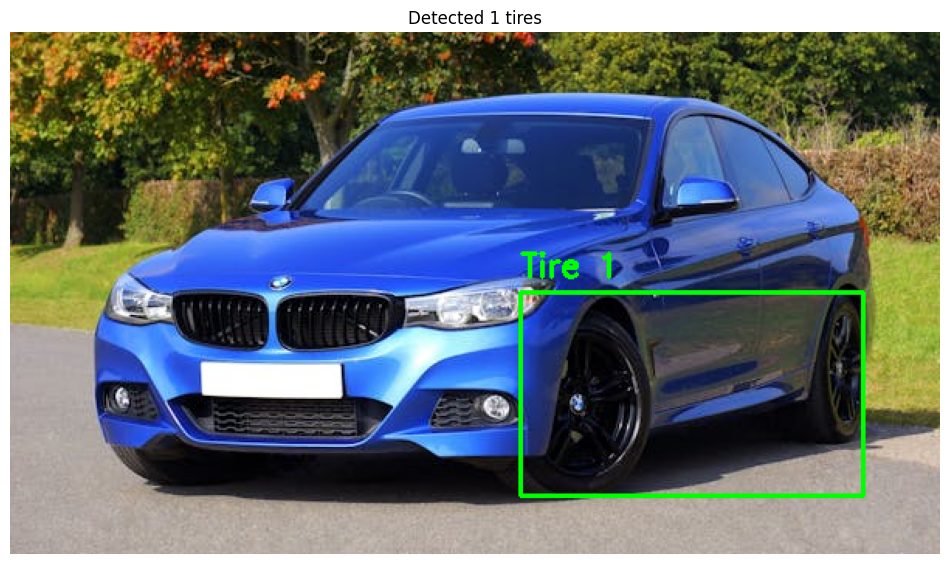


Analysis Results for /content/drive/MyDrive/Project_Data (1)/car.jpg:
Total tires detected: 1

Individual Tire Details:

Tire 1:
Position: Top-Left (329, 168), Bottom-Right (550, 299)
Dimensions: Width 221px, Height 131px


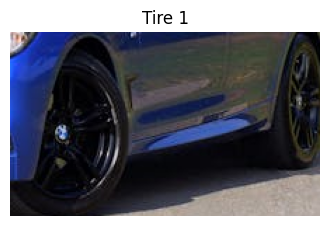

In [93]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Initialize YOLO model
model = YOLO(f"{master_dir}/yolov11_small_epoch100.pt")  # Your YOLO model

# Load your image
image_path = f"{master_dir}/car.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect tires
results = model(image_rgb)

# Process results
output_image = image_rgb.copy()
tire_count = 0

for result in results:
    if result.boxes is not None:
        for box in result.boxes:
            class_id = int(box.cls)
            class_name = model.names[class_id]

            if class_name == "wheel":  # Only process tires
                tire_count += 1
                x1, y1, x2, y2 = map(int, box.xyxy[0])

                # Draw bounding box
                cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Label with tire number
                label = f"Tire {tire_count}"
                cv2.putText(output_image, label, (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Display results
plt.figure(figsize=(12, 8))
plt.imshow(output_image)
plt.title(f"Detected {tire_count} tires")
plt.axis('off')
plt.show()

print(f"\nAnalysis Results for {image_path}:")
print(f"Total tires detected: {tire_count}")

# If you want to show each tire individually
if tire_count > 0:
    print("\nIndividual Tire Details:")
    for i, result in enumerate(results):
        if result.boxes is not None:
            for box in result.boxes:
                class_id = int(box.cls)
                if model.names[class_id] == "wheel":
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    print(f"\nTire {i+1}:")
                    print(f"Position: Top-Left ({x1}, {y1}), Bottom-Right ({x2}, {y2})")
                    print(f"Dimensions: Width {x2-x1}px, Height {y2-y1}px")

                    # Show individual tire crop
                    tire_roi = image_rgb[y1:y2, x1:x2]
                    plt.figure(figsize=(4, 4))
                    plt.imshow(tire_roi)
                    plt.title(f"Tire {i+1}")
                    plt.axis('off')
                    plt.show()

Angle between car center and front tyre: -96.22 degrees


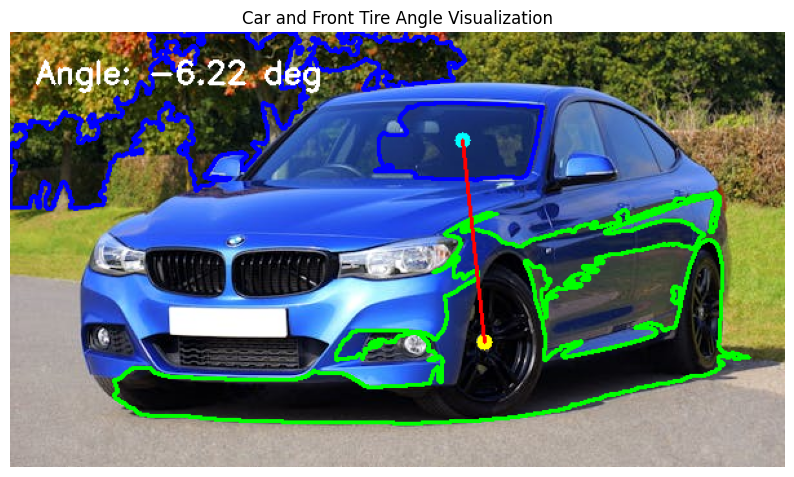

In [98]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

def find_angle(p1, p2):
    """Calculate angle between two points with respect to the horizontal axis."""
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    angle = math.degrees(math.atan2(dy, dx))
    return angle

def get_center(contour):
    """Compute the center of a contour."""
    M = cv2.moments(contour)
    if M["m00"] == 0:
        return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    return (cx, cy)

# Load image
image_path = '/content/drive/MyDrive/Project_Data (1)/car.jpg'
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found or unable to load.")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area (largest first)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Check for at least 3 contours (car + 2 tires)
if len(contours) < 3:
    print("Not enough contours found to identify car and front tyres.")
else:
    car_contour = contours[0]
    tyre_contour1 = contours[1]
    tyre_contour2 = contours[2]

    # Get centers
    car_center = get_center(car_contour)
    tyre_center1 = get_center(tyre_contour1)
    tyre_center2 = get_center(tyre_contour2)

    # Choose the more prominent tire (e.g., closer to car)
    if car_center and tyre_center1 and tyre_center2:
        dist1 = np.linalg.norm(np.array(car_center) - np.array(tyre_center1))
        dist2 = np.linalg.norm(np.array(car_center) - np.array(tyre_center2))
        front_tyre_center = tyre_center1 if dist1 < dist2 else tyre_center2

        # Draw everything
        output = image.copy()
        cv2.drawContours(output, [car_contour], -1, (0, 255, 0), 2)
        cv2.drawContours(output, [tyre_contour1, tyre_contour2], -1, (255, 0, 0), 2)

        cv2.circle(output, car_center, 6, (0, 255, 255), -1)
        cv2.circle(output, front_tyre_center, 6, (255, 255, 0), -1)
        cv2.line(output, car_center, front_tyre_center, (0, 0, 255), 2)

        angle = find_angle(car_center, front_tyre_center)
        print(f"Angle between car center and front tyre: {angle:.2f} degrees")

        cv2.putText(output, f"Angle: {angle + 90:.2f} deg", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        # Display result using matplotlib (more compatible than cv2.imshow for notebooks)
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Car and Front Tire Angle Visualization")
        plt.show()
    else:
        print("Could not compute centers for car or tires.")



0: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 2 front_left_lights, 1 front_right_light, 1 hood, 1 left_mirror, 1 right_mirror, 1 wheel, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

Analysis Results for /content/drive/MyDrive/Project_Data (1)/car.jpg:

Tire 1:
  Position: Top-Left (329, 168), Bottom-Right (550, 299)
  Dimensions: Width 221px, Height 131px
  Motion: Stationary (Sharpness: 727.94)


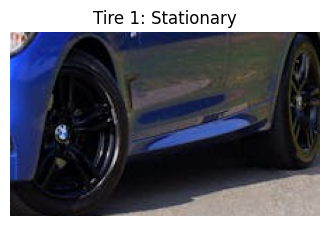

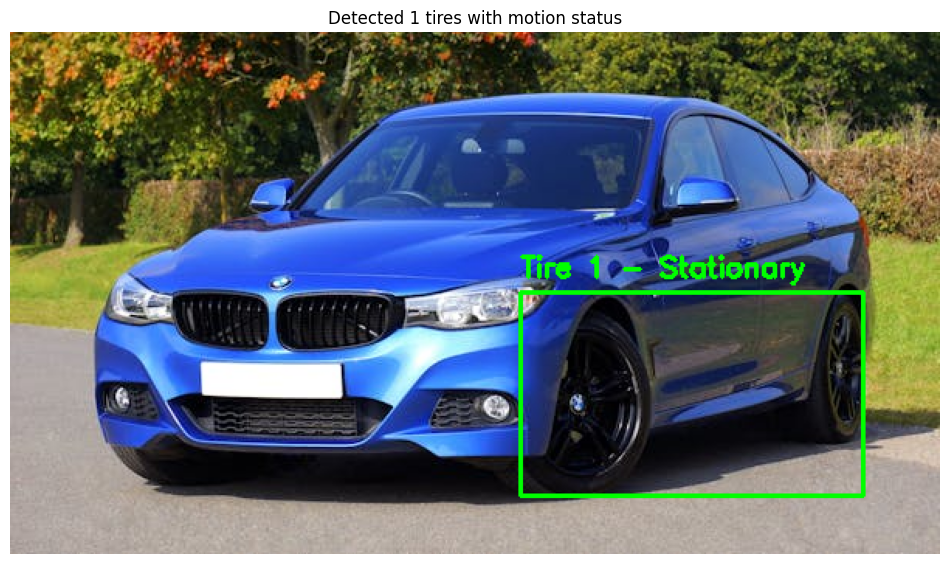

In [100]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def analyze_motion_state(tire_roi, threshold=100):
    """Determine if tire is moving or stationary based on image sharpness"""
    if len(tire_roi.shape) == 3:
        tire_roi = cv2.cvtColor(tire_roi, cv2.COLOR_BGR2GRAY)

    laplacian = cv2.Laplacian(tire_roi, cv2.CV_64F)
    variance = laplacian.var()

    if variance < threshold:
        return "Moving", variance
    else:
        return "Stationary", variance

# Set your paths
model_path = f"{master_dir}/yolov11_small_epoch100.pt"
image_path = f"{master_dir}/car.jpg"

# Load image and YOLO model
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
model = YOLO(model_path)

# Run detection
results = model(image_rgb)
output_image = image_rgb.copy()
tire_index = 0

print(f"\nAnalysis Results for {image_path}:\n")

for result in results:
    if result.boxes is not None:
        for box in result.boxes:
            class_id = int(box.cls)
            class_name = model.names[class_id]

            if class_name == "wheel":
                tire_index += 1
                x1, y1, x2, y2 = map(int, box.xyxy[0])

                # Extract tire ROI
                tire_roi = image[y1:y2, x1:x2]
                motion_status, sharpness = analyze_motion_state(tire_roi)

                # Draw on image
                label = f"Tire {tire_index} - {motion_status}"
                cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(output_image, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                # Print details
                print(f"Tire {tire_index}:")
                print(f"  Position: Top-Left ({x1}, {y1}), Bottom-Right ({x2}, {y2})")
                print(f"  Dimensions: Width {x2-x1}px, Height {y2-y1}px")
                print(f"  Motion: {motion_status} (Sharpness: {sharpness:.2f})")

                # Show cropped tire with label
                plt.figure(figsize=(4, 4))
                plt.imshow(cv2.cvtColor(tire_roi, cv2.COLOR_BGR2RGB))
                plt.title(f"Tire {tire_index}: {motion_status}")
                plt.axis('off')
                plt.show()

# Show full image with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(output_image)
plt.title(f"Detected {tire_index} tires with motion status")
plt.axis('off')
plt.show()



0: 480x640 1 front_bumper, 1 wheel, 238.7ms
Speed: 4.2ms preprocess, 238.7ms inference, 9.5ms postprocess per image at shape (1, 3, 480, 640)

Analysis Results for /content/drive/MyDrive/Project_Data (1)/moving2.jpg:

Tire 1:
  Position: Top-Left (144, 348), Bottom-Right (779, 493)
  Dimensions: Width 635px, Height 145px
  Motion: Moving (Sharpness: 54.36)


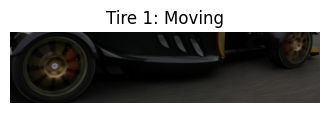

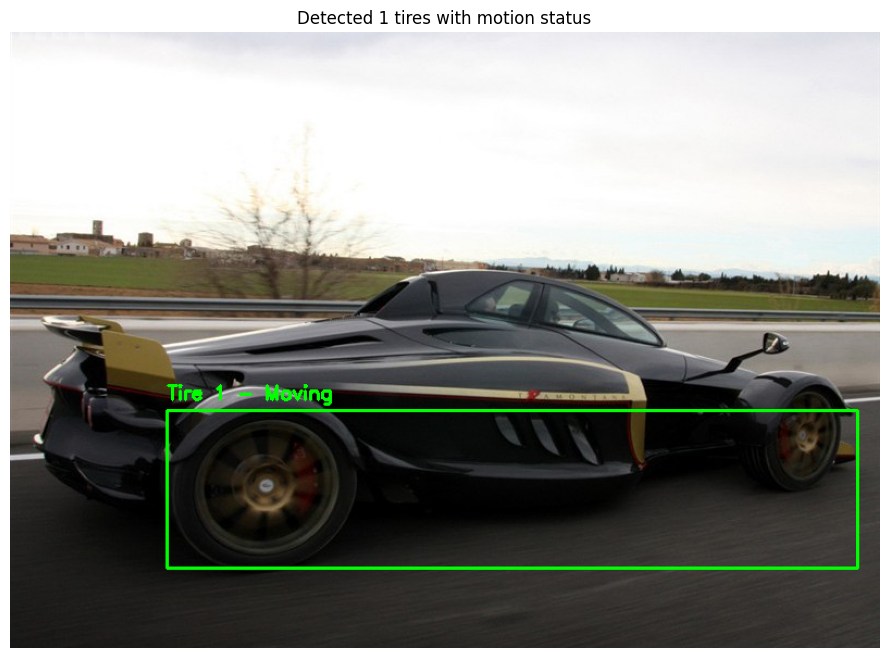

In [101]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def analyze_motion_state(tire_roi, threshold=100):
    """Determine if tire is moving or stationary based on image sharpness"""
    if len(tire_roi.shape) == 3:
        tire_roi = cv2.cvtColor(tire_roi, cv2.COLOR_BGR2GRAY)

    laplacian = cv2.Laplacian(tire_roi, cv2.CV_64F)
    variance = laplacian.var()

    if variance < threshold:
        return "Moving", variance
    else:
        return "Stationary", variance

# Set your paths
model_path = f"{master_dir}/yolov11_small_epoch100.pt"
image_path = f"{master_dir}/moving2.jpg"

# Load image and YOLO model
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
model = YOLO(model_path)

# Run detection
results = model(image_rgb)
output_image = image_rgb.copy()
tire_index = 0

print(f"\nAnalysis Results for {image_path}:\n")

for result in results:
    if result.boxes is not None:
        for box in result.boxes:
            class_id = int(box.cls)
            class_name = model.names[class_id]

            if class_name == "wheel":
                tire_index += 1
                x1, y1, x2, y2 = map(int, box.xyxy[0])

                # Extract tire ROI
                tire_roi = image[y1:y2, x1:x2]
                motion_status, sharpness = analyze_motion_state(tire_roi)

                # Draw on image
                label = f"Tire {tire_index} - {motion_status}"
                cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(output_image, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                # Print details
                print(f"Tire {tire_index}:")
                print(f"  Position: Top-Left ({x1}, {y1}), Bottom-Right ({x2}, {y2})")
                print(f"  Dimensions: Width {x2-x1}px, Height {y2-y1}px")
                print(f"  Motion: {motion_status} (Sharpness: {sharpness:.2f})")

                # Show cropped tire with label
                plt.figure(figsize=(4, 4))
                plt.imshow(cv2.cvtColor(tire_roi, cv2.COLOR_BGR2RGB))
                plt.title(f"Tire {tire_index}: {motion_status}")
                plt.axis('off')
                plt.show()

# Show full image with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(output_image)
plt.title(f"Detected {tire_index} tires with motion status")
plt.axis('off')
plt.show()



0: 384x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 2 front_left_lights, 1 front_right_light, 1 hood, 1 left_mirror, 1 right_mirror, 1 wheel, 44.0ms
Speed: 2.8ms preprocess, 44.0ms inference, 9.7ms postprocess per image at shape (1, 3, 384, 640)

Tire Orientation Analysis for: /content/drive/MyDrive/Project_Data (1)/car.jpg

Tire 1: T1: Stationary, Sharp=727.9, Angle=166.0°


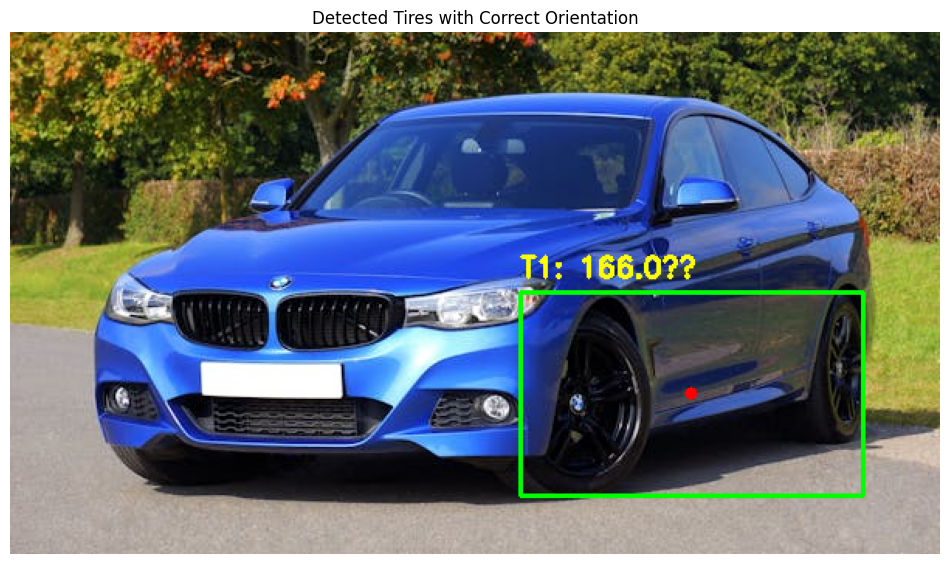

In [119]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def analyze_motion_state(tire_roi, threshold=100):
    gray = cv2.cvtColor(tire_roi, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    variance = laplacian.var()
    return ("Moving", variance) if variance < threshold else ("Stationary", variance)

def get_tire_orientation(tire_roi, draw_debug=False):
    gray = cv2.cvtColor(tire_roi, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    largest = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest)  # ((cx, cy), (w, h), angle)
    (cx, cy), (w, h), angle = rect

    # Fix OpenCV's angle ambiguity
    if w < h:
        angle = angle + 90

    # Optionally draw debug rectangle
    if draw_debug:
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(tire_roi, [box], 0, (255, 0, 0), 2)

    return angle


# === SETUP ===
master_dir = "/content/drive/MyDrive/Project_Data (1)"
model_path = f"{master_dir}/yolov11_small_epoch100.pt"
image_path = f"{master_dir}/car.jpg"

model = YOLO(model_path)
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
output_image = image.copy()

results = model(image_rgb)[0]
tire_index = 0

print(f"\nTire Orientation Analysis for: {image_path}\n")

for box in results.boxes:
    class_id = int(box.cls)
    class_name = model.names[class_id]
    if class_name != "wheel":
        continue

    tire_index += 1
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    tire_roi = image[y1:y2, x1:x2]

    motion, sharpness = analyze_motion_state(tire_roi)
    orientation = get_tire_orientation(tire_roi)

    label = f"T{tire_index}: {motion}, Sharp={sharpness:.1f}"
    if orientation is not None:
        label += f", Angle={orientation:.1f}°"
        angle_text = f"{orientation:.1f}°"
    else:
        angle_text = "??"

    # Draw visual info
    cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
    cv2.circle(output_image, (cx, cy), 4, (0, 0, 255), -1)
    cv2.putText(output_image, f"T{tire_index}: {angle_text}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    print(f"Tire {tire_index}: {label}")

# === DISPLAY ===
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Tires with Correct Orientation")
plt.axis('off')
plt.show()



0: 480x640 1 front_bumper, 1 wheel, 16.6ms
Speed: 2.4ms preprocess, 16.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

Tire Orientation Analysis for: /content/drive/MyDrive/Project_Data (1)/moving2.jpg

Tire 1: T1: Moving, Sharp=54.4, Angle=180.0°


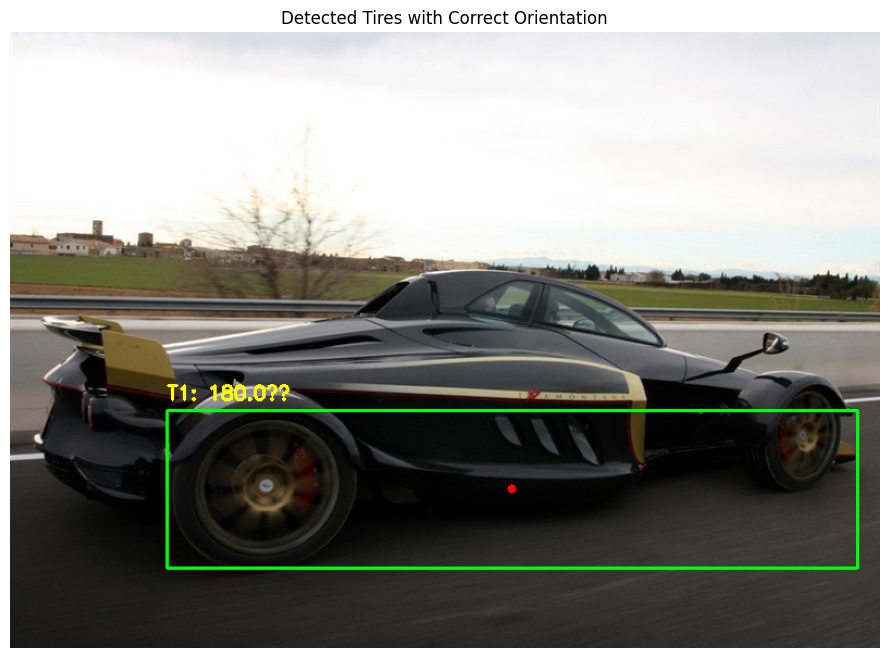

In [118]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def analyze_motion_state(tire_roi, threshold=100):
    gray = cv2.cvtColor(tire_roi, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    variance = laplacian.var()
    return ("Moving", variance) if variance < threshold else ("Stationary", variance)

def get_tire_orientation(tire_roi, draw_debug=False):
    gray = cv2.cvtColor(tire_roi, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    largest = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest)  # ((cx, cy), (w, h), angle)
    (cx, cy), (w, h), angle = rect

    # Fix OpenCV's angle ambiguity
    if w < h:
        angle = angle + 90

    # Optionally draw debug rectangle
    if draw_debug:
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(tire_roi, [box], 0, (255, 0, 0), 2)

    return angle


# === SETUP ===
master_dir = "/content/drive/MyDrive/Project_Data (1)"
model_path = f"{master_dir}/yolov11_small_epoch100.pt"
image_path = f"{master_dir}/moving2.jpg"

model = YOLO(model_path)
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
output_image = image.copy()

results = model(image_rgb)[0]
tire_index = 0

print(f"\nTire Orientation Analysis for: {image_path}\n")

for box in results.boxes:
    class_id = int(box.cls)
    class_name = model.names[class_id]
    if class_name != "wheel":
        continue

    tire_index += 1
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    tire_roi = image[y1:y2, x1:x2]

    motion, sharpness = analyze_motion_state(tire_roi)
    orientation = get_tire_orientation(tire_roi)

    label = f"T{tire_index}: {motion}, Sharp={sharpness:.1f}"
    if orientation is not None:
        corrected_angle = orientation - 180
        label += f", Angle={orientation:.1f}°"
        angle_text = f"{orientation:.1f}°"
    else:
        angle_text = "??"

    # Draw visual info
    cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
    cv2.circle(output_image, (cx, cy), 4, (0, 0, 255), -1)
    cv2.putText(output_image, f"T{tire_index}: {angle_text}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    print(f"Tire {tire_index}: {label}")

# === DISPLAY ===
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Tires with Correct Orientation")
plt.axis('off')
plt.show()


0: 448x640 1 front_bumper, 1 front_glass, 1 front_right_door, 2 wheels, 1034.0ms
Speed: 4.4ms preprocess, 1034.0ms inference, 26.7ms postprocess per image at shape (1, 3, 448, 640)

Tire Orientation Analysis for: /content/drive/MyDrive/Project_Data (1)/front-left-side-47.jpg

Tire 1: T1: Stationary, Sharp=1686.4, Angle=90.0°
Tire 2: T2: Stationary, Sharp=1008.8, Angle=23.2°


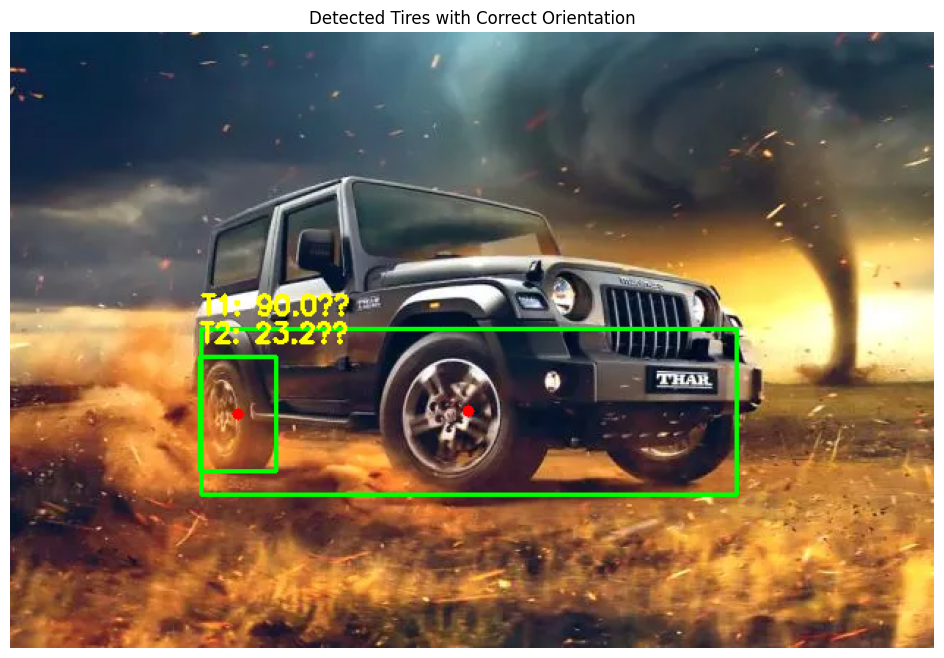

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def analyze_motion_state(tire_roi, threshold=100):
    gray = cv2.cvtColor(tire_roi, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    variance = laplacian.var()
    return ("Moving", variance) if variance < threshold else ("Stationary", variance)

def get_tire_orientation(tire_roi, draw_debug=False):
    gray = cv2.cvtColor(tire_roi, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    largest = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest)  # ((cx, cy), (w, h), angle)
    (cx, cy), (w, h), angle = rect

    # Fix OpenCV's angle ambiguity
    if w < h:
        angle = angle + 90

    # Optionally draw debug rectangle
    if draw_debug:
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(tire_roi, [box], 0, (255, 0, 0), 2)

    return angle


# === SETUP ===
master_dir = "/content/drive/MyDrive/Project_Data (1)"
model_path = f"{master_dir}/yolov11_small_epoch100.pt"
image_path = f"{master_dir}/front-left-side-47.jpg"

if not os.path.exists(image_path):
    print(f"Error: Image file not found at '{image_path}'")
    # Handle the error, e.g., exit or use a default image
else:
    model = YOLO(model_path)
    image = cv2.imread(image_path)

    # Check if image loaded successfully
    if image is None:
        print(f"Error: Could not load image from '{image_path}'")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        output_image = image.copy()

model = YOLO(model_path)
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
output_image = image.copy()

results = model(image_rgb)[0]
tire_index = 0

print(f"\nTire Orientation Analysis for: {image_path}\n")

for box in results.boxes:
    class_id = int(box.cls)
    class_name = model.names[class_id]
    if class_name != "wheel":
        continue

    tire_index += 1
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    tire_roi = image[y1:y2, x1:x2]

    motion, sharpness = analyze_motion_state(tire_roi)
    orientation = get_tire_orientation(tire_roi)

    label = f"T{tire_index}: {motion}, Sharp={sharpness:.1f}"
    if orientation is not None:
        corrected_angle = orientation - 180
        label += f", Angle={orientation:.1f}°"
        angle_text = f"{orientation:.1f}°"
    else:
        angle_text = "??"

    # Draw visual info
    cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
    cv2.circle(output_image, (cx, cy), 4, (0, 0, 255), -1)
    cv2.putText(output_image, f"T{tire_index}: {angle_text}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    print(f"Tire {tire_index}: {label}")

# === DISPLAY ===
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Tires with Correct Orientation")
plt.axis('off')
plt.show()